<head>
  <meta charset="UTF-8">
  <meta name="description" content="Unlocking Vision-Text Dual-Encoding: Multi-GPU Training of a CLIP-Like Model">
  <meta name="keywords" content="CLIP, Contrastive learning, multimodal learning, AMD Instinct GPU, MI300, Training, Language-Image, Vision-Text, Training">
</head>

# Unlocking Vision-Text Dual-Encoding: Multi-GPU Training of a CLIP-Like Model

**Author:** [Sean Song](../../authors/sean-song.md)\
**First published:** 16 Feb 2024

In this blog we will build a vision-text dual encoder model akin to CLIP and fine-tune it with the [COCO dataset](https://cocodataset.org/#overview).  This work is inspired by the principles of [CLIP](https://openai.com/research/clip) and [Hugging Face example](https://github.com/huggingface/transformers/tree/main/examples/pytorch/contrastive-image-text). The idea is to train a vision encoder and a text encoder jointly to project the representation of images and their descriptions into the same embedding space, such that the text embeddings are located near the embeddings of the images they describe. The objective during training is to maximize the similarity between the embeddings of image and text pairs in the batch while minimizing the similarity of embeddings for incorrect pairings. The model achieves this by learning a multi-modal embedding space. A symmetric cross entropy loss is optimized over these similarity scores. 

![CLIP structure](https://production-media.paperswithcode.com/methods/3d5d1009-6e3d-4570-8fd9-ee8f588003e7.png)


Vision-text dual encoder model can be applied to a wide range of downstream vision and language tasks such as image classification, object detection, image captioning, visual question answering, and more. Refer to our previous [Interacting with CLIP blog](https://github.com/ROCm/rocm-blogs/tree/release/blogs/artificial-intelligence/CLIP) to learn how to use a pretrained CLIP model to calculate the similarity between images and texts for Zero-Shot image classification.

## Setup:
This demo was created using the following settings. For comprehensive support details, please refer to the [ROCm documentation](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/).

* Hardware & OS:
  * [Supported AMD GPU](https://www.amd.com/en/products/accelerators/instinct.html)
  * Ubuntu 22.04.3 LTS
* Software:
  * [ROCm 5.7.0+](https://rocm.docs.amd.com/en/latest/)
  * [PyTorch 2.0+](https://pytorch.org/)

## 1. Getting started

Install the required libraries.

In [1]:
!pip install datasets accelerate matplotlib -U

It's recommended to install Transformers from source.

In [2]:
%%bash
rm -r transformers
git clone https://github.com/huggingface/transformers
cd transformers
pip install .

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
Updating files: 100% (4068/4068), done.


Processing /home/aac/CLIP/fine_tune/multi-gpu_8/transformers
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.8 MB/s eta 0:00:00:00:01
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8514198 sha256=edefb30ac9e9cd8e5dfe9bf699a695a7715a66d5eda78f2d66ff69d50f372468
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlkhya36/wheels/e9/70/ca/7126482ed2cfe1

Check the availability of the GPU on your system

In [3]:
!rocm-smi



========================= ROCm System Management Interface =========================
=================================== Concise Info ===================================
GPU  Temp (DieEdge)  AvgPwr  SCLK    MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
0    38.0c           42.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
1    41.0c           43.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
2    39.0c           43.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
3    41.0c           40.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
4    40.0c           43.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
5    39.0c           42.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
6    36.0c           43.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
7    39.0c           42.0W   800Mhz  1600Mhz  0%   auto  300.0W    0%   0%    
=============================== End of ROCm SMI Log ================================


## 2. Download COCO dataset
This example uses COCO dataset (2017) through a custom dataset script, which requires users to manually download the COCO dataset before training. Downloading time depends on the network speed. In my experience, it takes about 7 minutes when initiated from a terminal. It takes longer from a Jupyter notebook cell.

In [4]:
# %%bash
# mkdir data
# cd data
# wget http://images.cocodataset.org/zips/train2017.zip
# wget http://images.cocodataset.org/zips/val2017.zip
# wget http://images.cocodataset.org/zips/test2017.zip
# wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# wget http://images.cocodataset.org/annotations/image_info_test2017.zip
# cd ..

Once you have manually downloaded the COCO dataset, you can easily load it using the provided dataset loading script, ydshieh/coc_dataset_script.

In [5]:
import os
import datasets

COCO_DIR = os.path.join(os.getcwd(), "data")
ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir=COCO_DIR)
print(ds["train"])

/opt/conda/envs/py_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py_3.10/lib/python3.10/site-packages/datasets/load.py:1454: FutureWarning: The repository for ydshieh/coco_dataset_script contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ydshieh/coco_dataset_script
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/opt/conda/envs/py_3.10/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not f

Dataset({
    features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
    num_rows: 591753
})


Each data sample comprises the eight fields mentioned above. In the context of contrastive learning, pairs of images and captions serve as positive examples when they originate from the same sample, and as negative examples when they are unmatched and from different samples. Below are four samples from the training dataset.

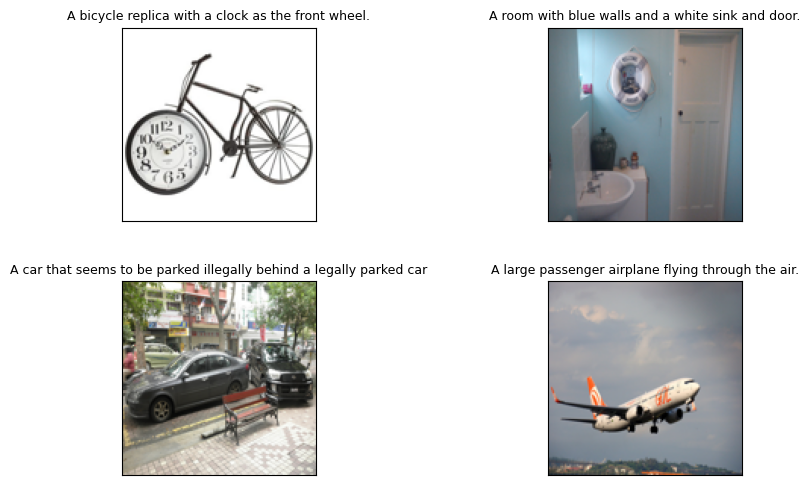

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

f, axarr = plt.subplots(2,2, figsize=(8,8))
plt.subplots_adjust(hspace=-0.3, wspace=1.2)
for index in range(4):
    image = Image.open(requests.get(ds["train"][index]['coco_url'], stream=True).raw).resize((128,128)).convert("RGB")
    caption = ds["train"][index]['caption']
    axarr[index//2,index%2].imshow(image)
    axarr[index//2,index%2].title.set_text(caption)
    axarr[index//2,index%2].title.set_size(9) 
    axarr[index//2,index%2].set_xticks([])
    axarr[index//2,index%2].set_yticks([])

## 3. Create a CLIP-like vision-text dual encoder model

We use [VisionTextDualEncoderModel](https://huggingface.co/docs/transformers/model_doc/vision-text-dual-encoder#visiontextdualencoder) to build the vision-text dual encoder model like the CLIP. This [VisionTextDualEncoderModel](https://huggingface.co/docs/transformers/model_doc/vision-text-dual-encoder#visiontextdualencoder) class can be used to initialize a vision-text dual encoder model with any pretrained vision autoencoding model as the vision encoder and a pretrained language model as the text encoder. In our case, we utilize [openai/clip-vit-base-patch32](https://huggingface.co/openai/clip-vit-base-patch32) and [roberta-base](https://huggingface.co/FacebookAI/roberta-base) as the vision encoder and text encoder respectively. 

In [7]:
from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor
)

model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "roberta-base"
)

# get the tokenizer and image processor from text and vision encoders 
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
image_processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

# save the model and processor
model.save_pretrained("clip-roberta")
processor.save_pretrained("clip-roberta")
# check the model  
print(model)

config.json: 100%|██████████| 4.19k/4.19k [00:00<00:00, 30.9MB/s]
pytorch_model.bin: 100%|██████████| 605M/605M [00:07<00:00, 84.5MB/s] 
/opt/conda/envs/py_3.10/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
config.json: 100%|██████████| 481/481 [00:00<00:00, 4.14MB/s]
model.safetensors: 100%|██████████| 499M/499M [00:05<00:00, 87.2MB/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The projection layer and logit sca

VisionTextDualEncoderModel(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()

Both the text and vision encoders are loaded with pre-trained weights. Because the projection layers are randomly initialized and we haven't jointly trained the two encoders, directly using this model to calculate similarity between images and texts won't yield satisfactory results. To explore this limitation, let's conduct a quick test. For ease of reference, let's name the constructed model `clip-roberta`.

### 3.1. Create test data for clip-roberta
First prepare the test data including four images and four text descriptions.

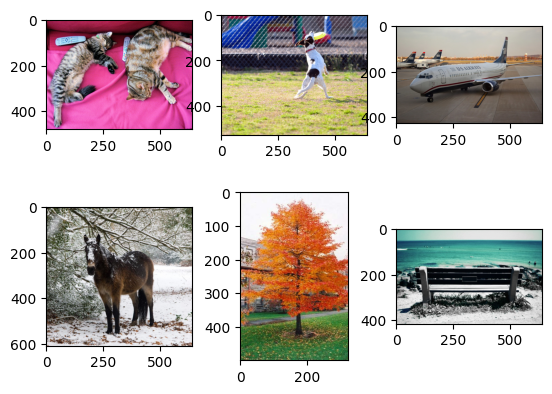

In [8]:
urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",
    "https://farm3.staticflickr.com/2674/5850229113_4fe05d5265_z.jpg",
    "http://farm6.staticflickr.com/5250/5255601114_e6bd308f74_z.jpg",
    "http://farm4.staticflickr.com/3389/3251688524_b35eaf2acd_z.jpg",
    "https://m.media-amazon.com/images/W/MEDIAX_849526-T1/images/I/51hDgswvNqL._AC_.jpg",
    "http://farm1.staticflickr.com/62/202534637_2dbb3071e5_z.jpg",
]
images = [Image.open(requests.get(url, stream=True).raw) for url in urls]

f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[0,2].imshow(images[2])
axarr[1,0].imshow(images[3])
axarr[1,1].imshow(images[4])
axarr[1,2].imshow(images[5])

texts = ["a photo of a cat", "a photo of a dog", "a photo of an airplane", "a photo of a horse", "a photo of a tree", "a photo of a bench"]

### 3.2. Process the images and texts and feed them to the clip-roberta model

In [9]:
# inference
inputs = processor(
    text=texts, images=images, return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(logits_per_image)
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

Unused or unrecognized kwargs: padding.


tensor([[ 0.4270,  0.4314,  0.4330,  0.4296,  0.4369,  0.4647],
        [ 1.2838,  1.2888,  1.2693,  1.2823,  1.2885,  1.2793],
        [ 0.9680,  0.9829,  0.9737,  0.9589,  0.9696,  0.9837],
        [ 0.4647,  0.4655,  0.4695,  0.4623,  0.4461,  0.4612],
        [-0.1244, -0.1225, -0.1151, -0.1315, -0.1097, -0.1017],
        [ 0.2710,  0.2707,  0.2837,  0.2689,  0.2669,  0.2833]],
       grad_fn=<PermuteBackward0>)


### 3.3. Visualize the similarity score 

Text(0.5, 1.0, 'Similarity between text and image features')

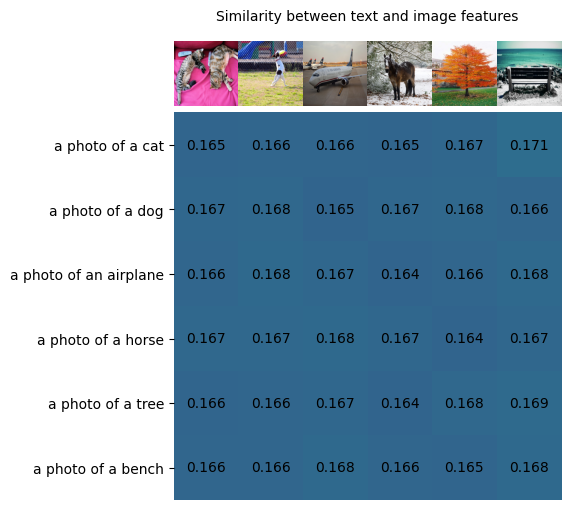

In [10]:
count = len(texts)
similarity = probs.detach().numpy()
plt.figure(figsize=(5, 9))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=10)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=10)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count-0.5, -1.8])

plt.title("Similarity between text and image features", size=10)

As mentioned earlier, due to the randomly initialized projection layers and separate training of the vision and text encoders, the model is currently unable to provide accurate results. It tends to assign similar scores to each pair of image and text, rather than accurately evaluating them individually. This is an expected outcome. Our subsequent action involves the joint training of the model, followed by reassessing its performance through the same test.

## 4. Train model with COCO dataset

You can easily log and monitor the training process with [Weights & Biases](https://wandb.ai/site). To use Weights & Biases, install the wandb package with:

In [11]:
!pip install wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 63.0 MB/s eta 0:00:00


In [12]:
import wandb
wandb.login()

# In case you don't want to use wandb, replace this cell with the following two lines
# import os
# os.environ["WANDB_DISABLED"] = "true"

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Finally, we are ready to train our `clip-roberta` model using the [run_clip.py](./src/run_clip.py) script. In our training, we utilize  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer) from Hugging Face in our training, which offer a convenient method to tailor the training process according to our needs. In our training, we trained the model for 5 epochs and saved checkpoints every 500 steps. You can increase this configuration to reduce the overhead of saving. Please see more  settings below for reference.

If your system is equipped with multiple GPUs, you can specify the number of available GPUs as an input to `nproc_per_node` (8 GPUs are used in the following training) to expedite the training process. The following table shows training runtime when utilizing varying numbers of GPUs (AMD Instinct MI210):


| Number of GPUs | 1  | 2 | 4 | 8 |
|---------------|:---:|:---:|:---:| :---:
| Train Runtime (hours) | 7.8 | 5.2 | 2.5 | 1.3|


In [ ]:
%%bash
torchrun \
    --nproc_per_node 8 ./run_clip.py \
    --output_dir ./clip-roberta-finetuned \
    --model_name_or_path ./clip-roberta \
    --data_dir $PWD/data \
    --dataset_name ydshieh/coco_dataset_script \
    --dataset_config_name=2017 \
    --image_column image_path \
    --caption_column caption \
    --remove_unused_columns=False \
    --do_train  --do_eval\
    --per_device_train_batch_size="64" \
    --per_device_eval_batch_size="64" \
    --learning_rate="5e-5" --warmup_steps="0" --weight_decay 0.1 \
    --num_train_epochs=5 \
    --overwrite_output_dir

After the completion of the training, the model `clip-roberta-finetuned` will be saved. You could find similar outputs at the beginning of the training. Simply click on the provided link to access and track the training metrics, such as the training loss.

> wandb: ⭐️ View project at https://wandb.ai/your-account/huggingface \
> wandb: 🚀 View run at https://wandb.ai/your-account/huggingface/runs/0q98bm04 \

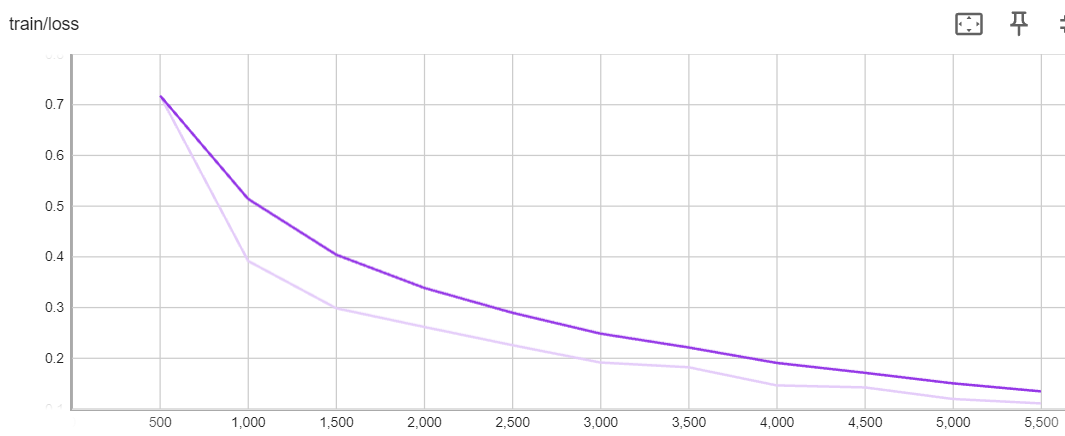
From the above training loss chart, we observe a consistent decrease in loss, which aligns with our expectations. However, the aim of this blog isn't to delve exhaustively into all possible training configurations to achieve an optimal model. Instead, its focus lies in guiding users on harnessing the power of AMD multi-GPU to unlock the potential of vision-text dual encoding.

Moving forward, we will conduct a test on the fine-tuned model (`clip-roberta-finetuned`) to ascertain its ability to accurately classify images that 'clip-roberta' struggles with.

## 8. Test the fine-tuned model 
Load the `clip-roberta-finetuned` model and test with the test data used previously.

In [14]:
model = VisionTextDualEncoderModel.from_pretrained(
    "./clip-roberta-finetuned"
)
# get the tokenizer and image processor from text and vision encoders 
tokenizer = AutoTokenizer.from_pretrained("./clip-roberta-finetuned")
image_processor = AutoImageProcessor.from_pretrained("./clip-roberta-finetuned")
processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)

In [15]:
# inference
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)

tensor([[9.8811e-01, 1.6277e-03, 9.7421e-04, 4.5114e-03, 3.1330e-03, 1.6449e-03],
        [9.7203e-04, 9.9060e-01, 3.4517e-04, 5.8935e-03, 1.9453e-03, 2.4285e-04],
        [1.3150e-05, 3.2590e-05, 9.9988e-01, 2.8037e-05, 1.6928e-05, 3.3404e-05],
        [5.4424e-03, 1.6018e-02, 5.6439e-04, 8.7959e-01, 9.7941e-02, 4.4352e-04],
        [9.0918e-07, 3.3684e-06, 8.4072e-07, 1.0356e-05, 9.9989e-01, 9.4088e-05],
        [6.3964e-05, 1.7778e-05, 9.8011e-06, 4.8208e-04, 5.2074e-05, 9.9937e-01]],
       grad_fn=<SoftmaxBackward0>)


Display the results and it becomes evident that each image has been correctly classified by `clip-roberta-finetuned` model. This successful outcome demonstrates the effectiveness of our training.

Text(0.5, 1.0, 'Similarity between text and image features')

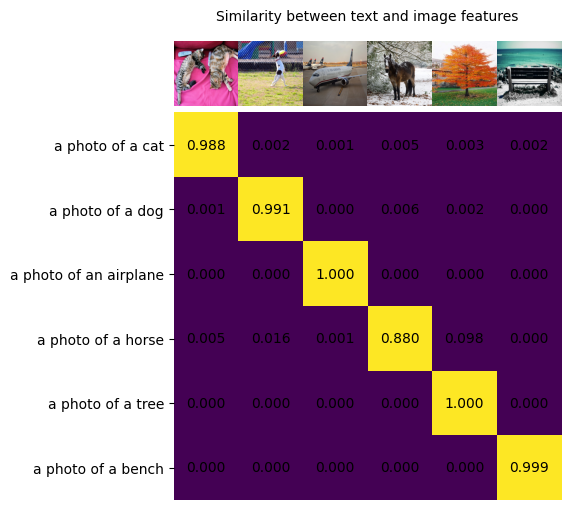

In [16]:
count = len(texts)
similarity = probs.detach().numpy()
plt.figure(figsize=(5, 9))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=10)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=10)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count-0.5, -1.8])

plt.title("Similarity between text and image features", size=10)

## Disclaimers

Third-party content is licensed to you directly by the third party that owns the content and is not licensed to you by AMD. ALL LINKED THIRD-PARTY CONTENT IS PROVIDED “AS IS” WITHOUT A WARRANTY OF ANY KIND. USE OF SUCH THIRD-PARTY CONTENT IS DONE AT YOUR SOLE DISCRETION AND UNDER NO CIRCUMSTANCES WILL AMD BE LIABLE TO YOU FOR ANY THIRD-PARTY CONTENT. YOU ASSUME ALL RISK AND ARE SOLELY RESPONSIBLE FOR ANY DAMAGES THAT MAY ARISE FROM YOUR USE OF THIRD-PARTY CONTENT.